## Masked Properly?
### Group 1

#### Image Classification using Tensor Flow

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import os
import struct
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

print(f'TensorFlow version= {tf.__version__}')
print(f"CUDA available= {tf.test.gpu_device_name()}")

# # Check CUDA TensorFlow
tf.test.is_built_with_cuda()

TensorFlow version= 2.8.0
CUDA available= 


True

In [2]:
#Parameters for tuning

NUM_EPOCHS = 3
# number of samples
# Note if samples is > than actual number, then actual number is used
num_CMFD_samples = 15000-1
num_RMFD_samples = 1500
num_google_samples = 145

## Preprocessing

1) Make sure the size of the images meet the input layer size requirements <br>
    a. Completed above, downsampled to 128 x 128 using opencv
2) Make sure images are rgb bgr like opencv reads them <br>
    Update On this, moved to gray scale due to memory issues <br>
3) Scale from 0 to 1 <br>

In [3]:
def get_images_from_folder(IMGSIZE, max_images, path, label):
    X, Y = [], []
    suffixes = ('.jpg', '.png', '.webp', '.jpeg')
    count = 0
    break_flag = False
    print(f'Path: {path}')
    for subdir, dirs, files in os.walk(path):
        for f in files:
            if f.endswith(suffixes):
                X += [cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(subdir,f)), cv2.COLOR_BGR2RGB), IMGSIZE)]
#                 X += [cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(path,f)), cv2.COLOR_BGR2GRAY), IMGSIZE)]
                Y += [label]
                count+= 1
                if (count+1) % 500 == 1:
                    print(f'read {count} images')
                if count == max_images:
                    break_flag = True
                    break
        if break_flag == True:
            break
    return np.array(X),np.array(Y)

In [4]:
# Downsample images to 128x128
IMGSIZE = (128, 128)
X, Y = [],[]
for i in range(6):
    X.append([])
    Y.append([])
# Get the synthetic data first
X_temp, Y_temp = get_images_from_folder(IMGSIZE, 40000, './CMFD/CMFD', [1,0])
ind = np.arange(len(X_temp))
np.random.shuffle(ind)
X[0] = X_temp[ind[0:num_CMFD_samples]]
X_validate = X_temp[ind[num_CMFD_samples:-1]]
Y[0] = Y_temp[ind[0:num_CMFD_samples]]
Y_validate = Y_temp[ind[num_CMFD_samples:-1]]
X_temp, Y_temp = get_images_from_folder(IMGSIZE, 40000, './IMFD/IMFD', [0,1])
ind = np.arange(len(X_temp))
np.random.shuffle(ind)
X[1] = X_temp[ind[0:num_CMFD_samples]]
Y[1] = Y_temp[ind[0:num_CMFD_samples]]
X_validate = np.concatenate((X_validate, X_temp[ind[num_CMFD_samples:-1]]))
Y_validate = np.concatenate((Y_validate, Y_temp[ind[num_CMFD_samples:-1]]))

# Data from the Real Masked Face Dataset
X_temp, Y_temp = get_images_from_folder(IMGSIZE, num_RMFD_samples, './RMFD/Masked_All', [1,0])
X[2] = X_temp
Y[2] = Y_temp
X_temp, Y_temp = get_images_from_folder(IMGSIZE, num_RMFD_samples, './RMFD/Improper_All', [0,1])
X[3] = X_temp
Y[3] = Y_temp

X_temp, Y_temp = get_images_from_folder(IMGSIZE, num_google_samples, './CMFD_google', [1,0])
X[4] = X_temp
Y[4] = Y_temp
X_temp, Y_temp = get_images_from_folder(IMGSIZE, num_google_samples, './IMFD_google', [0,1])
X[5] = X_temp
Y[5] = Y_temp
print(f'Synth image length: {len(X[0]) + len(X[1])} label length: {len(Y[0]) + len(Y[1])}')
print(f'RMFD image length: {len(X[2]) + len(X[3])} label length: {len(Y[2]) + len(Y[3])}')
print(f'Team image length: {len(X[4]) + len(X[5])} label length: {len(Y[4]) + len(Y[5])}')

Path: ./CMFD/CMFD
read 500 images
read 1000 images
read 1500 images
read 2000 images
read 2500 images
read 3000 images
read 3500 images
read 4000 images
read 4500 images
read 5000 images
read 5500 images
read 6000 images
read 6500 images
read 7000 images
read 7500 images
read 8000 images
read 8500 images
read 9000 images
read 9500 images
read 10000 images
read 10500 images
read 11000 images
read 11500 images
read 12000 images
read 12500 images
read 13000 images
read 13500 images
read 14000 images
read 14500 images
read 15000 images
read 15500 images
read 16000 images
read 16500 images
read 17000 images
read 17500 images
read 18000 images
read 18500 images
read 19000 images
read 19500 images
read 20000 images
read 20500 images
read 21000 images
read 21500 images
read 22000 images
read 22500 images
read 23000 images
read 23500 images
read 24000 images
read 24500 images
read 25000 images
read 25500 images
read 26000 images
read 26500 images
read 27000 images
read 27500 images
read 28000 i

### Randomly plot 8 samples from each of the databases

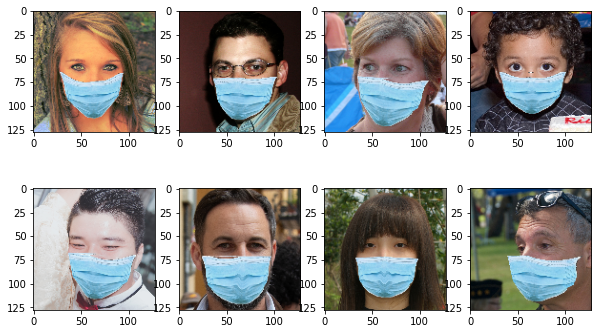

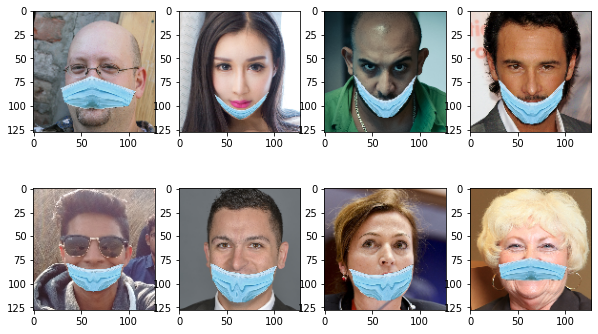

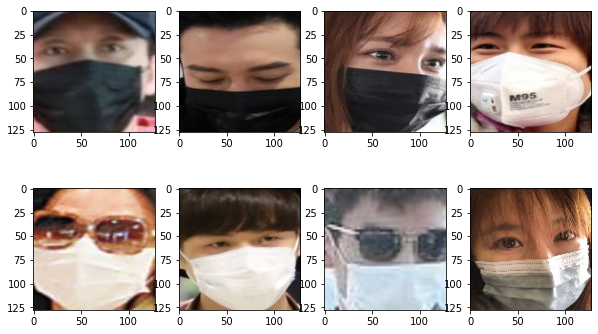

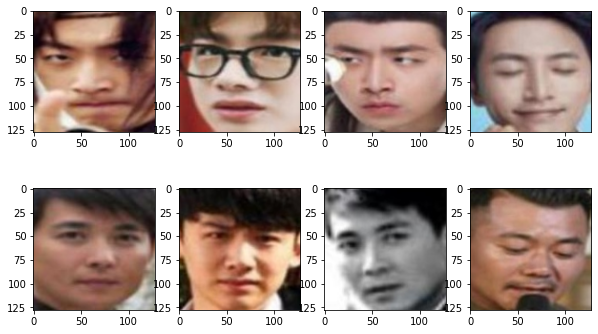

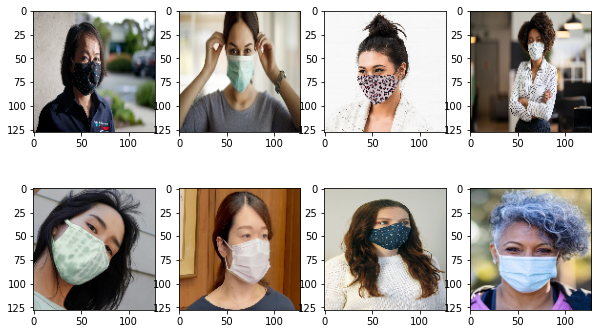

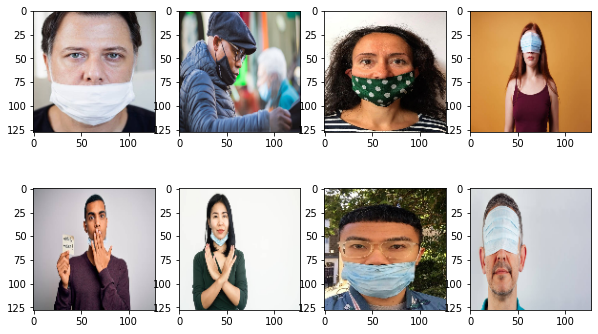

In [5]:
from random import randrange
# plot 25 random photos
for x in X:
    random_indx = []
    for i in range(8):
        random_indx.append(randrange(len(x)))

    fig, ax = plt.subplots(2,4,figsize=(10,6))
    count = 0
    for r in range(2):
        for c in range(4):
            ax[r][c].imshow(x[random_indx[count]],cmap='gray')
            count = count + 1
    plt.show()

### Create Train and Test samples 10 fold cross validation

Need to create a home-grown 10 fold to ensure each set has data from each of the databases

In [6]:
def k_fold_data_creation(X, n_folds):
    test_indices, train_indices = [],[]
    for j in range(n_folds):
        test_indices.append([])
        train_indices.append([])
        for i in range(len(X)):
            test_indices[j].append([])
            train_indices[j].append([])
    for t, x in enumerate(X):
        indices = np.arange(len(x))
        np.random.shuffle(indices)
        for i in range(n_folds):
            first_indx = int(i*len(x)/(n_folds))
            last_indx = int((i+1)*len(x)/(n_folds))
            test_indices[i][t] = indices[first_indx:last_indx]
            train_indices[i][t] = np.concatenate((indices[0:first_indx],indices[last_indx:-1]))
    return test_indices, train_indices
    

Create the folds for each of the k test iterations

In [7]:
test_ind, train_ind = k_fold_data_creation(X, 10)

### Create CNN

In [8]:
# Our full CNN neural network
def create_model():
    cnn1 = tf.keras.Sequential()

    cnn1.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5),
        data_format='channels_last',
        name='conv_1', activation='relu'))

    cnn1.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_1'))

    cnn1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5),
        name='conv_2', activation='relu'))

    cnn1.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

    cnn1.add(tf.keras.layers.Flatten())

    cnn1.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))

    cnn1.add(tf.keras.layers.Dense(units=2, name='fc_2', activation='softmax'))

        # Set a seed for repeatibility
    tf.random.set_seed(42)

    # Build the model
    cnn1.build(input_shape=(None, 128, 128, 3)) # None, 1024, 1024, 3 for rgb

    # Compile the model with the optimizer, loss function and metric
    cnn1.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'])

    return cnn1

In [ ]:
tp, fp, tn, fn = [], [], [], []
for i in range(3):
    tp.append([])
    fp.append([])
    tn.append([])
    fn.append([])
# k_fold x database size
for te_i, tr_i in zip(test_ind, train_ind):
    # create empty Train Index
    for i, train in enumerate(tr_i):
        if i == 0:
            X_train = X[i][train]
            Y_train = Y[i][train]
        else:
            X_train = np.concatenate((X_train, X[i][train]))
            Y_train = np.concatenate((Y_train, Y[i][train]))
    X_train = X_train/255
    print(f'{X_train.shape} {Y_train.shape}')
    cnn1 = create_model()
    history = cnn1.fit(X_train, Y_train,
        epochs=NUM_EPOCHS,
        shuffle=True)
    for i, test in enumerate(te_i):
        y_pred = cnn1.predict(X[i][test])
        y_pred = np.argmax(y_pred, axis=-1)
        y_check = np.argmax(Y[i][test], axis=-1) 
        m = int(i/2)
        if (i+2)%2 == 0: # even
            tp[m].append(sum(y_pred==y_check))
            fn[m].append(sum(y_pred!=y_check))
        else:
            tn[m].append(sum(y_pred==y_check))
            fp[m].append(sum(y_pred!=y_check))
        print(f'Size: {len(y_pred)} Accuracy {i}= {sum(y_pred==y_check)/len(y_pred)*100:.3f}')
        

(29956, 128, 128, 3) (29956, 2)
Epoch 1/3
937/937 [==============================] - 175s 185ms/step - loss: 0.0834 - accuracy: 0.9709
Epoch 2/3
937/937 [==============================] - 173s 185ms/step - loss: 0.0290 - accuracy: 0.9907
Epoch 3/3
937/937 [==============================] - 172s 184ms/step - loss: 0.0236 - accuracy: 0.9921
Size: 1499 Accuracy 0= 100.000
Size: 1499 Accuracy 1= 99.533
Size: 150 Accuracy 2= 98.667
Size: 150 Accuracy 3= 96.667
Size: 14 Accuracy 4= 50.000
Size: 14 Accuracy 5= 64.286
(29952, 128, 128, 3) (29952, 2)
Epoch 1/3
936/936 [==============================] - 173s 183ms/step - loss: 0.1064 - accuracy: 0.9603
Epoch 2/3
936/936 [==============================] - 170s 182ms/step - loss: 0.0298 - accuracy: 0.9894
Epoch 3/3
871/936 [==========================>...] - ETA: 11s - loss: 0.0248 - accuracy: 0.9912

### Report the metrics for each run and plot

In [ ]:
#ADD CONFUSION MATRIX CALCULATIONS

In [ ]:
#ADD PLOTS

In [ ]:
for i in range(6):
    if i == 0:
        X_t = X[i]
        Y_t = Y[i]
    else:
        X_t = np.concatenate((X_t, X[i]))
        Y_t = np.concatenate((Y_t, Y[i]))
X_train, X_test, Y_train, Y_test = train_test_split(X_t, Y_t, test_size=0.05, random_state=42)
cnn1 = create_model()
history = cnn1.fit(X_train, Y_train,
    epochs=8,
    shuffle=True)
# Training dataset
y_pred = cnn1.predict(X_train)
y_pred = np.argmax(y_pred, axis=-1)
y_check = np.argmax(Y_train, axis=-1)
print(f'Training Accuracy= {sum(y_pred==y_check)/len(y_pred)*100:.3f}')
# Testing dataset
y_pred = cnn1.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_check = np.argmax(Y_test, axis=-1)
print(f'Testing Accuracy= {sum(y_pred==y_check)/len(y_pred)*100:.3f}')

In [ ]:
# Add teste for the google database, determine failures, and plot
X_google = X[4]
X_google = np.concatenate((X_google, X[5]))
Y_google = Y[4]
Y_google = np.concatenate((Y_google, Y[5]))

y_pred = cnn1.predict(X_google)
y_pred = np.argmax(y_pred, axis=-1)
y_check = np.argmax(Y_google, axis=-1)
print(f'Testing Accuracy= {sum(y_pred==y_check)/len(y_pred)*100:.3f}')
failed_test = []
for i, y in enumerate(y_pred):
    if y != y_check[i]:
        failed_test.append(i)

In [ ]:
# Add test for rest of synth data


In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,9))
ax[0].plot(history.history['accuracy'])
ax[0].set_title('model accuracy')

ax[1].plot(history.history['loss'])
ax[1].set_title('model loss')

plt.show()